In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pandas_profiling
import json
import pymysql
import pickle
import seaborn as sns
import csv
import re
import os

from keplergl import KeplerGl 
from h3 import h3
from tqdm.notebook import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


# Data

## Business

In [2]:
conn = pymysql.connect('localhost', 'anderson', db='yelp', charset='utf8')

In [3]:
bs_data = pd.read_json('./yelp-dataset/yelp_academic_dataset_business.json',
                       lines=True)

# H3
bs_data['h3'] = bs_data[['latitude', 'longitude']].apply(
    lambda x: h3.geo_to_h3(x['latitude'], x['longitude'], 7), axis=1)

# Rank & Drop columns
bs_data['rank'] = bs_data['stars'] * bs_data['review_count']
bs_data.drop(['address', 'postal_code', 'hours', 'attributes'], axis=1, inplace=True)

# Category
bs_data['categories'] = bs_data['categories'].str.lower()
bs_data['categories'].fillna('', inplace=True)


## Business visualization

In [9]:
bs_data = bs_data.reset_index().drop('index', axis=1)
bs_data.to_csv('./yelp-dataset/business.csv', index=False)
print('shape:', bs_data.shape)
display(bs_data.head())

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
shape: (192609, 12)


,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,categories,h3,rank
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,33.522143,-112.018481,3.0,5,0,"golf, active life",8729b6d12ffffff,15.0
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,43.605499,-79.652289,2.5,128,1,"specialty food, restaurants, dim sum, imported...",872b9bcd1ffffff,320.0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,35.092564,-80.859132,4.0,170,1,"sushi bars, restaurants, japanese",8744d84a8ffffff,680.0
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,Goodyear,AZ,33.455613,-112.395596,5.0,3,1,"insurance, financial services",8729b69b0ffffff,15.0
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,Charlotte,NC,35.190012,-80.887223,4.0,4,1,"plumbing, shopping, local services, home servi...",8744d84c2ffffff,16.0


## Business Map Visualization

In [12]:
# Kepler
bs_m = KeplerGl(height=1000, width=1500)
bs_m.add_data(bs_data)
bs_m

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [29]:
pickle.dump(bs_m.get_state(), open('states/business_map.pickle', 'wb'))
bs_m.save_to_html(file_name='business.html')
!google-chrome business.html

Map saved to business.html!
Opening in existing browser session.


In [30]:
!embulk guess seed_business.yml -o config_business.yml
!embulk run config_business.yml

2019-11-14 17:41:52.072 +0900: Embulk v0.9.19
2019-11-14 17:41:52.374 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-14 17:41:53.658 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-14 17:41:54.064 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-14 17:41:54.101 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'business.csv'
2019-11-14 17:41:54.102 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-14 17:41:54.102 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/business.csv]
2019-11-14 17:41:54.109 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-14 17:41:54.167 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-14 17:41:54.177 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-14 17:

2019-11-14 17:41:58.957 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:58.957 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-14 17:41:58.962 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 17:41:58.976 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:58.977 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-11-14 17:41:59.158 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:59.158 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-14 17:41:59.160 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 17:41:59.172 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:59.172 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-11-14 17:41:59.256 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:59.256 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-14 17:41:59.257 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 17:41:59.261 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:59.261 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-11-14 17:41:59.416 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:59.416 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-14 17:41:59.419 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 17:41:59.426 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:59.427 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-11-14 17:41:59.519 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:59.519 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-14 17:41:59.521 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 17:41:59.529 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 17:41:59.530 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016e69138a25_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-11-14 17:42:04.546 +0900 [INFO] (0030:task-0000): > 0.31 seconds (loaded 2,718 rows in total)
2019-11-14 17:42:04.546 +0900 [INFO] (0030:task-0000): Loading 2,724 rows
2019-11-14 17:42:04.916 +0900 [INFO] (0030:task-0000): > 0.37 seconds (loaded 2,724 rows in total)
2019-11-14 17:42:04.917 +0900 [INFO] (0030:task-0000): Loading 2,732 rows
2019-11-14 17:42:05.561 +0900 [INFO] (0030:task-0000): > 0.64 seconds (loaded 2,732 rows in total)
2019-11-14 17:42:05.561 +0900 [INFO] (0030:task-0000): Loading 2,722 rows
2019-11-14 17:42:06.034 +0900 [INFO] (0030:task-0000): > 0.47 seconds (loaded 2,722 rows in total)
2019-11-14 17:42:06.034 +0900 [INFO] (0030:task-0000): Loading 2,735 rows
2019-11-14 17:42:06.436 +0900 [INFO] (0030:task-0000): > 0.40 seconds (loaded 2,735 rows in total)
2019-11-14 17:42:06.437 +0900 [INFO] (0030:task-0000): Loading 2,716 rows
2019-11-14 17:42:06.889 +0900 [INFO] (0030:task-0000): > 0.45 seconds (loaded 2,716 rows in total)
2019-11-14 17:42:06.890 +0900 [INFO]

2019-11-14 17:42:18.957 +0900 [INFO] (0030:task-0000): > 0.34 seconds (loaded 2,626 rows in total)
2019-11-14 17:42:18.957 +0900 [INFO] (0030:task-0000): Loading 2,619 rows
2019-11-14 17:42:19.218 +0900 [INFO] (0030:task-0000): > 0.26 seconds (loaded 2,619 rows in total)
2019-11-14 17:42:19.218 +0900 [INFO] (0030:task-0000): Loading 2,618 rows
2019-11-14 17:42:19.437 +0900 [INFO] (0030:task-0000): > 0.22 seconds (loaded 2,618 rows in total)
2019-11-14 17:42:19.437 +0900 [INFO] (0030:task-0000): Loading 2,651 rows
2019-11-14 17:42:19.680 +0900 [INFO] (0030:task-0000): > 0.24 seconds (loaded 2,651 rows in total)
2019-11-14 17:42:19.680 +0900 [INFO] (0030:task-0000): Loading 2,628 rows
2019-11-14 17:42:19.897 +0900 [INFO] (0030:task-0000): > 0.22 seconds (loaded 2,628 rows in total)
2019-11-14 17:42:19.897 +0900 [INFO] (0030:task-0000): Loading 2,623 rows
2019-11-14 17:42:20.040 +0900 [INFO] (0030:task-0000): > 0.14 seconds (loaded 2,623 rows in total)
2019-11-14 17:42:20.041 +0900 [INFO]

In [7]:
conn = pymysql.connect('localhost', 'anderson', db='yelp', charset='utf8')
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_business_on_business_id on business (business_id(40));')
    cursor.execute('create index if not exists idx_business_on_state on business (state(5));')
    cursor.execute('create index if not exists idx_business_on_h3 on business (h3(20));')
cursor.fetchall()

()

### 카테고리 

In [8]:
from collections import Counter

category_df = bs_data['categories'].str.split(',')

counter = {}
for row in category_df:
    if row is None:
        continue
    for category in row:
        category = category.strip().lower()
        counter.setdefault(category, 0)
        counter[category] += 1
counter = Counter(counter)
counter.most_common(10)

[('hotels & travel', 1368),
 ('event planning & services', 1367),
 ('hotels', 1342),
 ('restaurants', 261),
 ('venues & event spaces', 256),
 ('nightlife', 112),
 ('bars', 100),
 ('arts & entertainment', 91),
 ('casinos', 76),
 ('american (traditional)', 68)]

### star distribution

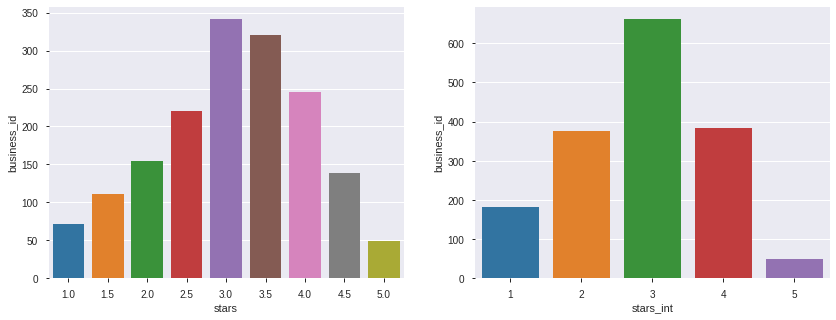

In [9]:
fig, plots = subplots(1, 2, figsize=(14, 5))

star_count = bs_data[['stars', 'business_id']].groupby('stars').count()
sns.barplot(star_count.index, 'business_id', data=star_count, ax=plots[0])

bs_data['stars_int'] = bs_data['stars'].astype('int')
star_count = bs_data[['stars_int', 'business_id']].groupby('stars_int').count()
sns.barplot(star_count.index, 'business_id', data=star_count, ax=plots[1])

## Attributes

In [10]:
# rep1 = {'"True"': 'true', '"False"': 'false', '\'': '"', "u'": '"', '"{': '{', '"}': '}',
#         'True': 'true', 'False': 'false'}
# rep2 = {'""': '"', } 
# regex1 = re.compile('|'.join(rep1.keys()))
# regex2 = re.compile('|'.join(rep2.keys()))

# att_data = []
# with open('yelp-dataset/yelp_academic_dataset_business.json', 'rt') as f:
    
#     for line in f:
#         attribute = json.loads(line)
#         if attribute['attributes'] is None:
#             continue
        
#         attribute = json.dumps(attribute['attributes'])
        
#         attribute = regex1.sub(lambda t: rep1[t.group(0)], attribute)
#         attribute = regex2.sub(lambda t: rep2[t.group(0)], attribute)
        
#         attribute = json.loads(attribute)
        
# #         print(attribute)

## Checkin Data

In [29]:
if os.path.exists('./yelp-dataset/checkin.csv'):
    os.remove('./yelp-dataset/checkin.csv')
    
ck_chunk = pd.read_json('./yelp-dataset/yelp_academic_dataset_checkin.json', lines=True, chunksize=1000)
business_ids = set(bs_data['business_id'].unique())

for ck_data in tqdm(ck_chunk):
    ck_data = ck_data[ck_data['business_id'].isin(business_ids)]
    ck_data.set_index('business_id', inplace=True)

    # Preprocessing
    def convert_datetimes(x):
        x = pd.to_datetime(x)
        return x

    dts_df = ck_data['date'].str.split(',').apply(convert_datetimes)
    dts_df = pd.DataFrame(dts_df.tolist(), index=dts_df.index).stack().reset_index()
    dts_df.drop('level_1', axis=1, inplace=True)
    dts_df.rename({0: 'checkin'}, axis=1, inplace=True)
    dts_df['year'] = dts_df['checkin'].dt.year
    dts_df['month'] = dts_df['checkin'].dt.month
    dts_df['hour'] = dts_df['checkin'].dt.hour

    dts_df.to_csv('./yelp-dataset/checkin.csv', mode='a', index=False)
    dts_df.head()

In [32]:
!embulk guess seed_checkin.yml -o config_checkin.yml
!embulk run config_checkin.yml

2019-11-15 10:57:55.990 +0900: Embulk v0.9.19
2019-11-15 10:57:56.277 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-15 10:57:57.576 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-15 10:57:57.979 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-15 10:57:58.015 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'checkin.csv'
2019-11-15 10:57:58.015 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-15 10:57:58.016 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/checkin.csv]
2019-11-15 10:57:58.023 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-15 10:57:58.086 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-15 10:57:58.098 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-15 10:57

2019-11-15 10:58:03.210 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-15 10:58:03.218 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-15 10:58:03.219 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `checkin_0000016e6cc81766_embulk` (`business_id`, `checkin`, `year`, `month`, `hour`) VALUES (?, ?, ?, ?, ?)
2019-11-15 10:58:03.222 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-15 10:58:03.231 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-15 10:58:03.231 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `ch

2019-11-15 10:58:03.363 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-15 10:58:03.369 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-15 10:58:03.370 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `checkin_0000016e6cc81766_embulk` (`business_id`, `checkin`, `year`, `month`, `hour`) VALUES (?, ?, ?, ?, ?)
2019-11-15 10:58:03.371 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-15 10:58:03.379 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-15 10:58:03.379 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `ch

2019-11-15 10:58:03.520 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-15 10:58:03.521 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `checkin_0000016e6cc81766_embulk` (`business_id`, `checkin`, `year`, `month`, `hour`) VALUES (?, ?, ?, ?, ?)
2019-11-15 10:58:03.522 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-15 10:58:03.552 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-15 10:58:03.552 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `checkin_0000016e6cc81766_embulk` (`business_id`, `checkin`, `year`, `month`, `hour`) VALUES (?, ?, ?, ?, ?)
2019-11-15 10:58:03.554 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL

2019-11-15 10:58:03.676 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-15 10:58:03.676 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `checkin_0000016e6cc81766_embulk` (`business_id`, `checkin`, `year`, `month`, `hour`) VALUES (?, ?, ?, ?, ?)
2019-11-15 10:58:03.677 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-15 10:58:03.684 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-15 10:58:03.684 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `checkin_0000016e6cc81766_embulk` (`business_id`, `checkin`, `year`, `month`, `hour`) VALUES (?, ?, ?, ?, ?)
2019-11-15 10:58:03.686 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL

2019-11-15 10:58:05.313 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:277006 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:05.486 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:388237 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:05.799 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:515441 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:06.096 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:630889 (org.embulk.spi.time.TimestampParseException: Cannot p

2019-11-15 10:58:12.737 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:3711254 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:12.995 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:3828894 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:13.268 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:3927204 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:13.403 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:4027927 (org.embulk.spi.time.TimestampParseException: Cann

2019-11-15 10:58:20.431 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:7482814 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:20.828 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:7591514 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:21.314 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:7721377 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:58:21.318 +0900 [INFO] (embulk-output-executor-0): Loading 107,548 rows
2019-11-15 10:58:21.318 +0900 [INFO] (embulk-output-executor-9): Loading 107,548 rows
2019-11-15 10:58:2

2019-11-15 10:59:12.596 +0900 [INFO] (embulk-output-executor-36): > 51.26 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:17.303 +0900 [INFO] (embulk-output-executor-28): > 55.97 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:33.859 +0900 [INFO] (embulk-output-executor-59): > 72.50 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:33.909 +0900 [INFO] (embulk-output-executor-39): > 72.57 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:34.093 +0900 [INFO] (embulk-output-executor-67): > 72.71 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:34.626 +0900 [INFO] (embulk-output-executor-35): > 73.29 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:34.948 +0900 [INFO] (embulk-output-executor-24): > 73.62 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:34.956 +0900 [INFO] (embulk-output-executor-68): > 73.58 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:36.145 +0900 [INFO] (embulk-output-executor-57): > 74.78 seconds (loaded 107,54

2019-11-15 10:59:39.603 +0900 [INFO] (embulk-output-executor-69): > 78.22 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:39.616 +0900 [INFO] (embulk-output-executor-2): > 78.30 seconds (loaded 107,548 rows in total)
2019-11-15 10:59:39.794 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:7840781 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:59:40.281 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:7935351 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:59:40.410 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:8047457 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): b

2019-11-15 10:59:46.801 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:11235957 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:59:46.911 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:11333636 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:59:47.183 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:11452368 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:59:47.457 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:11563177 (org.embulk.spi.time.TimestampParseException: 

2019-11-15 10:59:53.737 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:14630059 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:59:53.844 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:14725306 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:59:54.114 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:14827333 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 10:59:54.206 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:14908552 (org.embulk.spi.time.TimestampParseException: 

2019-11-15 11:02:48.941 +0900 [INFO] (embulk-output-executor-17): > 173.68 seconds (loaded 215,096 rows in total)
2019-11-15 11:02:54.158 +0900 [INFO] (embulk-output-executor-11): > 178.90 seconds (loaded 215,096 rows in total)
2019-11-15 11:02:54.177 +0900 [INFO] (embulk-output-executor-18): > 178.92 seconds (loaded 215,096 rows in total)
2019-11-15 11:02:54.753 +0900 [INFO] (embulk-output-executor-4): > 179.50 seconds (loaded 215,096 rows in total)
2019-11-15 11:02:55.512 +0900 [INFO] (embulk-output-executor-10): > 180.26 seconds (loaded 215,096 rows in total)
2019-11-15 11:02:55.778 +0900 [INFO] (embulk-output-executor-9): > 180.53 seconds (loaded 215,096 rows in total)
2019-11-15 11:02:57.526 +0900 [INFO] (embulk-output-executor-3): > 182.28 seconds (loaded 215,096 rows in total)
2019-11-15 11:02:58.002 +0900 [INFO] (embulk-output-executor-6): > 182.75 seconds (loaded 215,096 rows in total)
2019-11-15 11:02:58.421 +0900 [INFO] (embulk-output-executor-70): > 183.12 seconds (loaded 2

2019-11-15 11:03:02.624 +0900 [INFO] (embulk-output-executor-25): > 187.36 seconds (loaded 215,096 rows in total)
2019-11-15 11:03:02.639 +0900 [INFO] (embulk-output-executor-39): > 187.37 seconds (loaded 215,096 rows in total)
2019-11-15 11:03:02.728 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:15569642 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 11:03:03.061 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:15678525 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 11:03:03.416 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:15803506 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%

2019-11-15 11:03:10.020 +0900 [WARN] (0030:task-0000): Skipped line /home/anderson/@python/Yelp-Tutorial/./yelp-dataset/checkin.csv:18984749 (org.embulk.spi.time.TimestampParseException: Cannot parse 'checkin' by '%Y-%m-%d %H:%M:%S'): business_id,checkin,year,month,hour
2019-11-15 11:03:10.302 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:11.142 +0900 [INFO] (0030:task-0000): > 0.84 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:11.144 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:11.996 +0900 [INFO] (0030:task-0000): > 0.85 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:11.996 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:12.840 +0900 [INFO] (0030:task-0000): > 0.84 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:12.841 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:13.612 +0900 [INFO] (0030:task-0000): > 0.77 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:13.612 +

2019-11-15 11:03:43.240 +0900 [INFO] (0030:task-0000): > 0.87 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:43.241 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:43.831 +0900 [INFO] (0030:task-0000): > 0.59 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:43.831 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:44.401 +0900 [INFO] (0030:task-0000): > 0.57 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:44.401 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:45.367 +0900 [INFO] (0030:task-0000): > 0.97 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:45.367 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:46.279 +0900 [INFO] (0030:task-0000): > 0.91 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:46.280 +0900 [INFO] (0030:task-0000): Loading 50,100 rows
2019-11-15 11:03:47.235 +0900 [INFO] (0030:task-0000): > 0.96 seconds (loaded 265,196 rows in total)
2019-11-15 11:03:47

In [33]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_checkin_on_business_id on checkin (business_id(40));')
    cursor.execute('create index if not exists idx_checkin_on_year on checkin (year);')
    cursor.execute('create index if not exists idx_checkin_on_month on checkin (month);')
    
cursor.fetchall()

InterfaceError: (0, '')

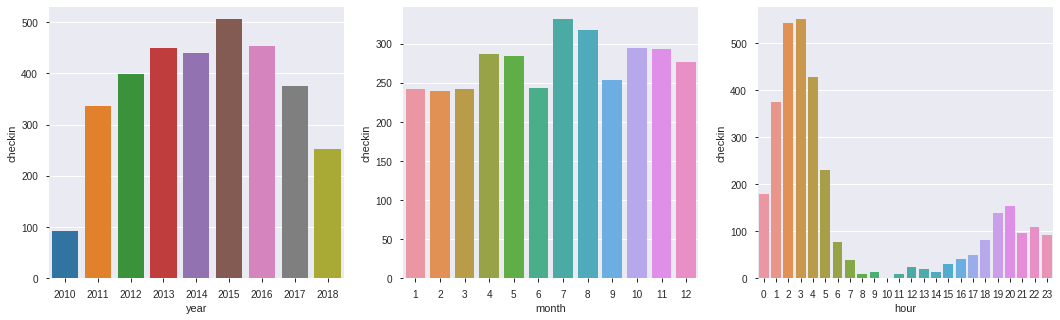

In [36]:
fig, plots = subplots(1, 3, figsize=(18, 5))
plots = plots.reshape(-1)

year_df = dts_df.groupby('year')['checkin'].count()
month_df = dts_df.groupby('month')['checkin'].count()
hour_df = dts_df.groupby('hour')['checkin'].count()

sns.barplot(year_df.index, year_df, ax=plots[0])
sns.barplot(month_df.index, month_df, ax=plots[1])
sns.barplot(hour_df.index, hour_df, ax=plots[2])


## Review

In [15]:
!embulk guess seed_review.yml -o config_review.yml
!embulk run config_review.yml

2019-11-13 18:25:46.437 +0900: Embulk v0.9.19
2019-11-13 18:25:46.742 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-13 18:25:47.990 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-13 18:25:48.379 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-13 18:25:48.413 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'yelp_academic_dataset_review.json'
2019-11-13 18:25:48.413 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-13 18:25:48.414 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/yelp_academic_dataset_review.json]
2019-11-13 18:25:48.420 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-13 18:25:48.474 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-13 18:25:48.488 +0900 [INFO] (0001:guess): Lo

2019-11-13 18:25:52.390 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:25:52.390 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `review_0000016e64155d31_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:25:52.392 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:25:52.397 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:25:52.397 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `review_0000016e64155d31_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:25:52.398 +0900 [INFO] (0030:task-0000): Connecti

2019-11-13 18:25:52.492 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:25:52.492 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `review_0000016e64155d31_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:25:52.493 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:25:52.497 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:25:52.497 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `review_0000016e64155d31_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:25:52.498 +0900 [INFO] (0030:task-0000): Connecti

2019-11-13 18:25:52.599 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:25:52.599 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `review_0000016e64155d31_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:25:52.600 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:25:52.605 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:25:52.605 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `review_0000016e64155d31_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:25:52.606 +0900 [INFO] (0030:task-0000): Connecti

2019-11-13 18:25:52.752 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:25:52.757 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:25:52.757 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `review_0000016e64155d31_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:25:52.758 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:25:52.762 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:25:52.762 +0900 [IN

2019-11-13 18:26:05.297 +0900 [INFO] (embulk-output-executor-5): Loading 11,425 rows
2019-11-13 18:26:05.297 +0900 [INFO] (embulk-output-executor-12): Loading 11,440 rows
2019-11-13 18:26:05.297 +0900 [INFO] (embulk-output-executor-6): Loading 11,497 rows
2019-11-13 18:26:05.297 +0900 [INFO] (embulk-output-executor-9): Loading 11,441 rows
2019-11-13 18:26:05.298 +0900 [INFO] (embulk-output-executor-30): Loading 11,483 rows
2019-11-13 18:26:05.299 +0900 [INFO] (embulk-output-executor-34): Loading 11,380 rows
2019-11-13 18:26:05.299 +0900 [INFO] (embulk-output-executor-37): Loading 11,349 rows
2019-11-13 18:26:05.300 +0900 [INFO] (embulk-output-executor-41): Loading 11,383 rows
2019-11-13 18:26:05.300 +0900 [INFO] (embulk-output-executor-40): Loading 11,353 rows
2019-11-13 18:26:05.301 +0900 [INFO] (embulk-output-executor-42): Loading 11,401 rows
2019-11-13 18:26:05.302 +0900 [INFO] (embulk-output-executor-51): Loading 11,435 rows
2019-11-13 18:26:05.304 +0900 [INFO] (embulk-output-execu

2019-11-13 18:26:33.208 +0900 [INFO] (embulk-output-executor-69): > 20.84 seconds (loaded 11,281 rows in total)
2019-11-13 18:26:33.228 +0900 [INFO] (embulk-output-executor-46): > 20.87 seconds (loaded 11,375 rows in total)
2019-11-13 18:26:33.377 +0900 [INFO] (embulk-output-executor-66): > 21.01 seconds (loaded 11,317 rows in total)
2019-11-13 18:26:33.878 +0900 [INFO] (embulk-output-executor-18): > 21.53 seconds (loaded 11,367 rows in total)
2019-11-13 18:26:33.924 +0900 [INFO] (embulk-output-executor-23): > 21.58 seconds (loaded 11,339 rows in total)
2019-11-13 18:26:34.023 +0900 [INFO] (embulk-output-executor-52): > 21.66 seconds (loaded 11,427 rows in total)
2019-11-13 18:26:34.160 +0900 [INFO] (embulk-output-executor-16): > 21.82 seconds (loaded 11,299 rows in total)
2019-11-13 18:26:34.162 +0900 [INFO] (embulk-output-executor-45): > 21.80 seconds (loaded 11,397 rows in total)
2019-11-13 18:26:34.162 +0900 [INFO] (embulk-output-executor-38): > 21.81 seconds (loaded 11,258 rows in

2019-11-13 18:27:18.306 +0900 [INFO] (embulk-output-executor-11): > 6.75 seconds (loaded 22,590 rows in total)
2019-11-13 18:27:18.309 +0900 [INFO] (embulk-output-executor-12): Loading 11,337 rows
2019-11-13 18:27:18.311 +0900 [INFO] (embulk-output-executor-16): Loading 11,311 rows
2019-11-13 18:27:18.315 +0900 [INFO] (embulk-output-executor-23): Loading 11,322 rows
2019-11-13 18:27:18.321 +0900 [INFO] (embulk-output-executor-33): Loading 11,323 rows
2019-11-13 18:27:18.341 +0900 [INFO] (embulk-output-executor-34): > 6.78 seconds (loaded 22,663 rows in total)
2019-11-13 18:27:18.345 +0900 [INFO] (embulk-output-executor-36): Loading 11,382 rows
2019-11-13 18:27:18.349 +0900 [INFO] (embulk-output-executor-40): Loading 11,381 rows
2019-11-13 18:27:19.580 +0900 [INFO] (embulk-output-executor-68): > 8.02 seconds (loaded 22,837 rows in total)
2019-11-13 18:27:19.626 +0900 [INFO] (embulk-output-executor-0): > 8.06 seconds (loaded 22,632 rows in total)
2019-11-13 18:27:19.650 +0900 [INFO] (emb

2019-11-13 18:27:53.283 +0900 [INFO] (embulk-output-executor-7): > 21.13 seconds (loaded 22,751 rows in total)
2019-11-13 18:27:53.304 +0900 [INFO] (embulk-output-executor-8): > 21.15 seconds (loaded 22,818 rows in total)
2019-11-13 18:27:53.337 +0900 [INFO] (embulk-output-executor-60): > 21.20 seconds (loaded 22,869 rows in total)
2019-11-13 18:27:53.339 +0900 [INFO] (embulk-output-executor-62): Loading 11,221 rows
2019-11-13 18:27:53.340 +0900 [INFO] (embulk-output-executor-63): Loading 11,389 rows
2019-11-13 18:27:53.341 +0900 [INFO] (embulk-output-executor-67): Loading 11,344 rows
2019-11-13 18:27:53.535 +0900 [INFO] (embulk-output-executor-3): > 21.39 seconds (loaded 22,737 rows in total)
2019-11-13 18:27:53.587 +0900 [INFO] (embulk-output-executor-69): > 21.44 seconds (loaded 22,579 rows in total)
2019-11-13 18:27:53.592 +0900 [INFO] (embulk-output-executor-71): Loading 11,388 rows
2019-11-13 18:27:53.607 +0900 [INFO] (embulk-output-executor-2): Loading 11,322 rows
2019-11-13 18:

2019-11-13 18:28:49.037 +0900 [INFO] (embulk-output-executor-33): Loading 11,309 rows
2019-11-13 18:28:49.037 +0900 [INFO] (embulk-output-executor-34): Loading 11,301 rows
2019-11-13 18:28:49.038 +0900 [INFO] (embulk-output-executor-36): Loading 11,328 rows
2019-11-13 18:28:49.041 +0900 [INFO] (embulk-output-executor-42): Loading 11,224 rows
2019-11-13 18:28:49.045 +0900 [INFO] (embulk-output-executor-51): Loading 11,352 rows
2019-11-13 18:28:49.045 +0900 [INFO] (embulk-output-executor-53): Loading 11,415 rows
2019-11-13 18:28:49.049 +0900 [INFO] (embulk-output-executor-65): Loading 11,343 rows
2019-11-13 18:28:49.050 +0900 [INFO] (embulk-output-executor-68): Loading 11,433 rows
2019-11-13 18:28:49.053 +0900 [INFO] (embulk-output-executor-5): Loading 11,451 rows
2019-11-13 18:28:49.053 +0900 [INFO] (embulk-output-executor-6): Loading 11,332 rows
2019-11-13 18:28:49.055 +0900 [INFO] (embulk-output-executor-12): Loading 11,514 rows
2019-11-13 18:28:49.055 +0900 [INFO] (embulk-output-exec

2019-11-13 18:29:30.206 +0900 [INFO] (embulk-output-executor-27): Loading 11,375 rows
2019-11-13 18:29:30.207 +0900 [INFO] (embulk-output-executor-28): Loading 11,399 rows
2019-11-13 18:29:30.209 +0900 [INFO] (embulk-output-executor-31): Loading 11,377 rows
2019-11-13 18:29:30.210 +0900 [INFO] (embulk-output-executor-32): Loading 11,483 rows
2019-11-13 18:29:30.211 +0900 [INFO] (embulk-output-executor-35): Loading 11,413 rows
2019-11-13 18:29:30.212 +0900 [INFO] (embulk-output-executor-39): Loading 11,391 rows
2019-11-13 18:29:30.214 +0900 [INFO] (embulk-output-executor-45): Loading 11,323 rows
2019-11-13 18:29:30.215 +0900 [INFO] (embulk-output-executor-47): Loading 11,400 rows
2019-11-13 18:29:30.216 +0900 [INFO] (embulk-output-executor-48): Loading 11,459 rows
2019-11-13 18:29:30.216 +0900 [INFO] (embulk-output-executor-50): Loading 11,340 rows
2019-11-13 18:29:43.526 +0900 [INFO] (embulk-output-executor-54): > 14.76 seconds (loaded 34,198 rows in total)
2019-11-13 18:29:45.827 +090

2019-11-13 18:30:31.035 +0900 [INFO] (embulk-output-executor-42): > 6.40 seconds (loaded 44,925 rows in total)
2019-11-13 18:30:31.037 +0900 [INFO] (embulk-output-executor-44): Loading 11,095 rows
2019-11-13 18:30:31.040 +0900 [INFO] (embulk-output-executor-51): Loading 11,298 rows
2019-11-13 18:30:31.041 +0900 [INFO] (embulk-output-executor-52): Loading 11,252 rows
2019-11-13 18:30:31.041 +0900 [INFO] (embulk-output-executor-11): > 6.39 seconds (loaded 45,259 rows in total)
2019-11-13 18:30:31.044 +0900 [INFO] (embulk-output-executor-60): Loading 11,305 rows
2019-11-13 18:30:31.044 +0900 [INFO] (embulk-output-executor-61): Loading 11,242 rows
2019-11-13 18:30:31.047 +0900 [INFO] (embulk-output-executor-68): Loading 11,380 rows
2019-11-13 18:30:31.051 +0900 [INFO] (embulk-output-executor-5): Loading 11,241 rows
2019-11-13 18:30:31.057 +0900 [INFO] (embulk-output-executor-37): > 6.39 seconds (loaded 45,147 rows in total)
2019-11-13 18:30:31.059 +0900 [INFO] (embulk-output-executor-17): 

2019-11-13 18:30:41.486 +0900 [INFO] (embulk-output-executor-66): > 0.93 seconds (loaded 45,072 rows in total)
2019-11-13 18:30:41.492 +0900 [INFO] (embulk-output-executor-69): Loading 11,205 rows
2019-11-13 18:30:41.568 +0900 [INFO] (embulk-output-executor-71): > 0.97 seconds (loaded 45,480 rows in total)
2019-11-13 18:30:45.726 +0900 [INFO] (embulk-output-executor-10): > 5.01 seconds (loaded 45,328 rows in total)
2019-11-13 18:30:45.836 +0900 [INFO] (embulk-output-executor-6): > 5.12 seconds (loaded 45,273 rows in total)
2019-11-13 18:30:45.860 +0900 [INFO] (embulk-output-executor-2): > 5.14 seconds (loaded 45,145 rows in total)
2019-11-13 18:30:45.863 +0900 [INFO] (embulk-output-executor-7): Loading 11,347 rows
2019-11-13 18:30:45.907 +0900 [INFO] (embulk-output-executor-18): > 5.18 seconds (loaded 45,538 rows in total)
2019-11-13 18:30:46.154 +0900 [INFO] (embulk-output-executor-9): > 5.44 seconds (loaded 45,342 rows in total)
2019-11-13 18:30:46.157 +0900 [INFO] (embulk-output-exe

2019-11-13 18:31:09.894 +0900 [INFO] (embulk-output-executor-60): > 5.22 seconds (loaded 56,513 rows in total)
2019-11-13 18:31:10.012 +0900 [INFO] (embulk-output-executor-0): > 5.33 seconds (loaded 56,637 rows in total)
2019-11-13 18:31:10.040 +0900 [INFO] (embulk-output-executor-11): > 4.33 seconds (loaded 56,510 rows in total)
2019-11-13 18:31:10.065 +0900 [INFO] (embulk-output-executor-51): > 5.39 seconds (loaded 57,014 rows in total)
2019-11-13 18:31:10.094 +0900 [INFO] (embulk-output-executor-36): > 5.42 seconds (loaded 56,754 rows in total)
2019-11-13 18:31:10.097 +0900 [INFO] (embulk-output-executor-41): Loading 11,293 rows
2019-11-13 18:31:10.098 +0900 [INFO] (embulk-output-executor-44): Loading 11,231 rows
2019-11-13 18:31:10.099 +0900 [INFO] (embulk-output-executor-46): Loading 11,236 rows
2019-11-13 18:31:10.104 +0900 [INFO] (embulk-output-executor-54): Loading 11,353 rows
2019-11-13 18:31:10.108 +0900 [INFO] (embulk-output-executor-59): Loading 11,189 rows
2019-11-13 18:31

2019-11-13 18:31:21.998 +0900 [INFO] (embulk-output-executor-50): Loading 11,347 rows
2019-11-13 18:31:22.006 +0900 [INFO] (embulk-output-executor-55): Loading 11,373 rows
2019-11-13 18:31:22.007 +0900 [INFO] (embulk-output-executor-57): Loading 11,346 rows
2019-11-13 18:31:22.715 +0900 [INFO] (embulk-output-executor-63): > 1.28 seconds (loaded 56,499 rows in total)
2019-11-13 18:31:22.739 +0900 [INFO] (embulk-output-executor-62): > 1.31 seconds (loaded 56,337 rows in total)
2019-11-13 18:31:22.743 +0900 [INFO] (embulk-output-executor-69): Loading 11,457 rows
2019-11-13 18:31:22.744 +0900 [INFO] (embulk-output-executor-70): Loading 11,226 rows
2019-11-13 18:31:26.813 +0900 [INFO] (embulk-output-executor-21): > 4.84 seconds (loaded 56,636 rows in total)
2019-11-13 18:31:26.852 +0900 [INFO] (embulk-output-executor-7): > 4.88 seconds (loaded 56,770 rows in total)
2019-11-13 18:31:26.901 +0900 [INFO] (embulk-output-executor-6): > 4.93 seconds (loaded 56,388 rows in total)
2019-11-13 18:31:

2019-11-13 18:31:47.213 +0900 [INFO] (embulk-output-executor-0): > 4.12 seconds (loaded 68,027 rows in total)
2019-11-13 18:31:47.215 +0900 [INFO] (embulk-output-executor-1): Loading 11,409 rows
2019-11-13 18:31:47.216 +0900 [INFO] (embulk-output-executor-3): Loading 11,257 rows
2019-11-13 18:31:47.218 +0900 [INFO] (embulk-output-executor-5): Loading 11,387 rows
2019-11-13 18:31:47.339 +0900 [INFO] (embulk-output-executor-12): > 4.24 seconds (loaded 68,382 rows in total)
2019-11-13 18:31:48.339 +0900 [INFO] (embulk-output-executor-34): > 4.47 seconds (loaded 67,813 rows in total)
2019-11-13 18:31:48.401 +0900 [INFO] (embulk-output-executor-46): > 4.45 seconds (loaded 68,052 rows in total)
2019-11-13 18:31:48.405 +0900 [INFO] (embulk-output-executor-26): > 4.53 seconds (loaded 67,872 rows in total)
2019-11-13 18:31:48.408 +0900 [INFO] (embulk-output-executor-30): Loading 11,344 rows
2019-11-13 18:31:48.411 +0900 [INFO] (embulk-output-executor-37): Loading 11,280 rows
2019-11-13 18:31:48

2019-11-13 18:32:06.813 +0900 [INFO] (embulk-output-executor-7): > 5.65 seconds (loaded 68,255 rows in total)
2019-11-13 18:32:06.817 +0900 [INFO] (embulk-output-executor-13): Loading 11,552 rows
2019-11-13 18:32:06.817 +0900 [INFO] (embulk-output-executor-14): Loading 11,429 rows
2019-11-13 18:32:06.844 +0900 [INFO] (embulk-output-executor-21): > 5.65 seconds (loaded 67,992 rows in total)
2019-11-13 18:32:07.847 +0900 [INFO] (embulk-output-executor-70): > 6.50 seconds (loaded 67,708 rows in total)
2019-11-13 18:32:07.915 +0900 [INFO] (embulk-output-executor-63): > 6.62 seconds (loaded 67,879 rows in total)
2019-11-13 18:32:07.916 +0900 [INFO] (embulk-output-executor-50): > 6.62 seconds (loaded 68,241 rows in total)
2019-11-13 18:32:07.919 +0900 [INFO] (embulk-output-executor-48): > 6.63 seconds (loaded 67,909 rows in total)
2019-11-13 18:32:07.925 +0900 [INFO] (embulk-output-executor-57): Loading 11,366 rows
2019-11-13 18:32:07.930 +0900 [INFO] (embulk-output-executor-69): Loading 11,

2019-11-13 18:32:31.805 +0900 [INFO] (embulk-output-executor-51): > 3.80 seconds (loaded 79,769 rows in total)
2019-11-13 18:32:31.809 +0900 [INFO] (embulk-output-executor-44): > 3.96 seconds (loaded 78,987 rows in total)
2019-11-13 18:32:31.814 +0900 [INFO] (embulk-output-executor-53): Loading 11,271 rows
2019-11-13 18:32:31.816 +0900 [INFO] (embulk-output-executor-58): Loading 11,282 rows
2019-11-13 18:32:31.816 +0900 [INFO] (embulk-output-executor-60): Loading 11,322 rows
2019-11-13 18:32:31.817 +0900 [INFO] (embulk-output-executor-62): Loading 11,311 rows
2019-11-13 18:32:34.545 +0900 [INFO] (embulk-output-executor-60): > 2.73 seconds (loaded 79,206 rows in total)
2019-11-13 18:32:34.775 +0900 [INFO] (embulk-output-executor-3): > 3.00 seconds (loaded 78,921 rows in total)
2019-11-13 18:32:34.787 +0900 [INFO] (embulk-output-executor-62): > 2.97 seconds (loaded 79,091 rows in total)
2019-11-13 18:32:34.848 +0900 [INFO] (embulk-output-executor-10): > 3.07 seconds (loaded 79,048 rows i

2019-11-13 18:32:46.262 +0900 [INFO] (embulk-output-executor-24): > 1.95 seconds (loaded 79,084 rows in total)
2019-11-13 18:32:46.365 +0900 [INFO] (embulk-output-executor-22): > 2.06 seconds (loaded 79,504 rows in total)
2019-11-13 18:32:46.545 +0900 [INFO] (embulk-output-executor-55): > 2.25 seconds (loaded 79,516 rows in total)
2019-11-13 18:32:46.547 +0900 [INFO] (embulk-output-executor-56): Loading 11,248 rows
2019-11-13 18:32:46.547 +0900 [INFO] (embulk-output-executor-57): Loading 11,315 rows
2019-11-13 18:32:46.554 +0900 [INFO] (embulk-output-executor-69): Loading 11,327 rows
2019-11-13 18:32:46.555 +0900 [INFO] (embulk-output-executor-70): Loading 11,140 rows
2019-11-13 18:32:46.763 +0900 [INFO] (embulk-output-executor-39): > 2.44 seconds (loaded 79,517 rows in total)
2019-11-13 18:32:46.867 +0900 [INFO] (embulk-output-executor-14): > 2.56 seconds (loaded 79,253 rows in total)
2019-11-13 18:32:46.878 +0900 [INFO] (embulk-output-executor-35): Loading 11,213 rows
2019-11-13 18:3

2019-11-13 18:33:05.473 +0900 [INFO] (embulk-output-executor-1): > 2.98 seconds (loaded 90,196 rows in total)
2019-11-13 18:33:05.473 +0900 [INFO] (embulk-output-executor-6): > 2.98 seconds (loaded 90,554 rows in total)
2019-11-13 18:33:05.473 +0900 [INFO] (embulk-output-executor-12): > 2.98 seconds (loaded 90,906 rows in total)
2019-11-13 18:33:05.474 +0900 [INFO] (embulk-output-executor-5): Loading 11,236 rows
2019-11-13 18:33:05.475 +0900 [INFO] (embulk-output-executor-10): Loading 11,323 rows
2019-11-13 18:33:05.485 +0900 [INFO] (embulk-output-executor-44): > 2.83 seconds (loaded 90,283 rows in total)
2019-11-13 18:33:05.520 +0900 [INFO] (embulk-output-executor-11): > 3.02 seconds (loaded 90,458 rows in total)
2019-11-13 18:33:05.527 +0900 [INFO] (embulk-output-executor-18): Loading 11,290 rows
2019-11-13 18:33:05.528 +0900 [INFO] (embulk-output-executor-20): Loading 11,262 rows
2019-11-13 18:33:05.529 +0900 [INFO] (embulk-output-executor-21): Loading 11,272 rows
2019-11-13 18:33:0

2019-11-13 18:33:24.124 +0900 [INFO] (embulk-output-executor-70): > 2.08 seconds (loaded 90,078 rows in total)
2019-11-13 18:33:24.127 +0900 [INFO] (embulk-output-executor-7): > 2.08 seconds (loaded 90,688 rows in total)
2019-11-13 18:33:24.141 +0900 [INFO] (embulk-output-executor-35): Loading 11,267 rows
2019-11-13 18:33:25.475 +0900 [INFO] (embulk-output-executor-56): > 1.40 seconds (loaded 90,289 rows in total)
2019-11-13 18:33:25.823 +0900 [INFO] (embulk-output-executor-39): > 1.76 seconds (loaded 90,787 rows in total)
2019-11-13 18:33:25.990 +0900 [INFO] (embulk-output-executor-43): > 1.92 seconds (loaded 90,233 rows in total)
2019-11-13 18:33:26.020 +0900 [INFO] (embulk-output-executor-35): > 1.88 seconds (loaded 90,364 rows in total)
2019-11-13 18:33:27.608 +0900 [INFO] (0030:task-0000): Loading 2,379 rows
2019-11-13 18:33:27.833 +0900 [INFO] (0030:task-0000): > 0.23 seconds (loaded 92,883 rows in total)
2019-11-13 18:33:27.835 +0900 [INFO] (0030:task-0000): Loading 2,413 rows
2

2019-11-13 18:33:35.639 +0900 [INFO] (0030:task-0000): > 0.22 seconds (loaded 92,515 rows in total)
2019-11-13 18:33:35.639 +0900 [INFO] (0030:task-0000): Loading 2,400 rows
2019-11-13 18:33:35.873 +0900 [INFO] (0030:task-0000): > 0.23 seconds (loaded 92,858 rows in total)
2019-11-13 18:33:35.873 +0900 [INFO] (0030:task-0000): Loading 2,212 rows
2019-11-13 18:33:36.137 +0900 [INFO] (0030:task-0000): > 0.26 seconds (loaded 92,999 rows in total)
2019-11-13 18:33:36.137 +0900 [INFO] (0030:task-0000): Loading 2,551 rows
2019-11-13 18:33:36.348 +0900 [INFO] (0030:task-0000): > 0.21 seconds (loaded 92,985 rows in total)
2019-11-13 18:33:36.348 +0900 [INFO] (0030:task-0000): Loading 2,441 rows
2019-11-13 18:33:36.543 +0900 [INFO] (0030:task-0000): > 0.20 seconds (loaded 92,849 rows in total)
2019-11-13 18:33:36.543 +0900 [INFO] (0030:task-0000): Loading 2,444 rows
2019-11-13 18:33:36.741 +0900 [INFO] (0030:task-0000): > 0.20 seconds (loaded 92,717 rows in total)
2019-11-13 18:33:36.741 +0900 

In [16]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_review_on_user_id on review (user_id(40));')
    cursor.execute('create index if not exists idx_review_on_business_id on review (business_id(40));')
    cursor.execute('create index if not exists idx_review_on_date on review (date);')
    
cursor.fetchall()

()

## Tip Data


In [17]:
!embulk guess seed_tip.yml -o config_tip.yml
!embulk run config_tip.yml

2019-11-13 18:37:53.873 +0900: Embulk v0.9.19
2019-11-13 18:37:54.168 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-13 18:37:55.359 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-13 18:37:55.735 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-13 18:37:55.768 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'yelp_academic_dataset_tip.json'
2019-11-13 18:37:55.769 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-13 18:37:55.769 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/yelp_academic_dataset_tip.json]
2019-11-13 18:37:55.774 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-13 18:37:55.835 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-13 18:37:55.847 +0900 [INFO] (0001:guess): Loaded p

2019-11-13 18:37:59.696 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:37:59.701 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:37:59.701 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `tip_0000016e64207635_embulk` (`user_id`, `business_id`, `text`, `compliment_count`, `date`) VALUES (?, ?, ?, ?, ?)
2019-11-13 18:37:59.703 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:37:59.707 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:37:59.708 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT I

2019-11-13 18:37:59.801 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:37:59.802 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `tip_0000016e64207635_embulk` (`user_id`, `business_id`, `text`, `compliment_count`, `date`) VALUES (?, ?, ?, ?, ?)
2019-11-13 18:37:59.802 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:37:59.806 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:37:59.806 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `tip_0000016e64207635_embulk` (`user_id`, `business_id`, `text`, `compliment_count`, `date`) VALUES (?, ?, ?, ?, ?)
2019-11-13 18:37:59.807 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAliv

2019-11-13 18:37:59.905 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:37:59.905 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `tip_0000016e64207635_embulk` (`user_id`, `business_id`, `text`, `compliment_count`, `date`) VALUES (?, ?, ?, ?, ?)
2019-11-13 18:37:59.905 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:37:59.909 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:37:59.909 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `tip_0000016e64207635_embulk` (`user_id`, `business_id`, `text`, `compliment_count`, `date`) VALUES (?, ?, ?, ?, ?)
2019-11-13 18:37:59.910 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAliv

2019-11-13 18:38:07.351 +0900 [INFO] (0030:task-0000): Loading 17,146 rows
2019-11-13 18:38:07.785 +0900 [INFO] (0030:task-0000): > 0.43 seconds (loaded 17,146 rows in total)
2019-11-13 18:38:07.786 +0900 [INFO] (0030:task-0000): Loading 17,069 rows
2019-11-13 18:38:08.083 +0900 [INFO] (0030:task-0000): > 0.30 seconds (loaded 17,069 rows in total)
2019-11-13 18:38:08.083 +0900 [INFO] (0030:task-0000): Loading 17,007 rows
2019-11-13 18:38:08.437 +0900 [INFO] (0030:task-0000): > 0.35 seconds (loaded 17,007 rows in total)
2019-11-13 18:38:08.438 +0900 [INFO] (0030:task-0000): Loading 16,994 rows
2019-11-13 18:38:08.780 +0900 [INFO] (0030:task-0000): > 0.34 seconds (loaded 16,994 rows in total)
2019-11-13 18:38:08.781 +0900 [INFO] (0030:task-0000): Loading 17,055 rows
2019-11-13 18:38:09.100 +0900 [INFO] (0030:task-0000): > 0.32 seconds (loaded 17,055 rows in total)
2019-11-13 18:38:09.100 +0900 [INFO] (0030:task-0000): Loading 17,029 rows
2019-11-13 18:38:09.428 +0900 [INFO] (0030:task-00

2019-11-13 18:38:21.627 +0900 [INFO] (0030:task-0000): > 0.32 seconds (loaded 16,891 rows in total)
2019-11-13 18:38:21.628 +0900 [INFO] (0030:task-0000): Loading 17,045 rows
2019-11-13 18:38:21.953 +0900 [INFO] (0030:task-0000): > 0.33 seconds (loaded 17,045 rows in total)
2019-11-13 18:38:21.954 +0900 [INFO] (0030:task-0000): Loading 16,893 rows
2019-11-13 18:38:22.269 +0900 [INFO] (0030:task-0000): > 0.32 seconds (loaded 16,893 rows in total)
2019-11-13 18:38:22.269 +0900 [INFO] (0030:task-0000): Loading 16,958 rows
2019-11-13 18:38:22.595 +0900 [INFO] (0030:task-0000): > 0.33 seconds (loaded 16,958 rows in total)
2019-11-13 18:38:22.596 +0900 [INFO] (0030:task-0000): Loading 16,972 rows
2019-11-13 18:38:22.927 +0900 [INFO] (0030:task-0000): > 0.33 seconds (loaded 16,972 rows in total)
2019-11-13 18:38:22.927 +0900 [INFO] (0030:task-0000): Loading 16,903 rows
2019-11-13 18:38:23.253 +0900 [INFO] (0030:task-0000): > 0.33 seconds (loaded 16,903 rows in total)
2019-11-13 18:38:23.254 +

In [18]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_tip_on_user_id on tip (user_id(40));')
    cursor.execute('create index if not exists idx_tip_on_business_id on tip (business_id(40));')
    cursor.execute('create index if not exists idx_tip_on_date on tip (date);')
    
cursor.fetchall()

()

## User

In [19]:
!embulk guess seed_user.yml -o config_user.yml
!embulk run config_user.yml

2019-11-13 18:38:41.885 +0900: Embulk v0.9.19
2019-11-13 18:38:42.174 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-13 18:38:43.393 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-13 18:38:43.803 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-13 18:38:43.839 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'yelp_academic_dataset_user.json'
2019-11-13 18:38:43.839 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-13 18:38:43.840 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/yelp_academic_dataset_user.json]
2019-11-13 18:38:43.846 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-13 18:38:43.903 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-13 18:38:43.914 +0900 [INFO] (0001:guess): Loaded

2019-11-13 18:38:47.800 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:47.800 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `user_0000016e64213228_embulk` (`user_id`, `name`, `review_count`, `useful`, `funny`, `cool`, `elite`, `fans`, `average_stars`, `compliment_hot`, `compliment_more`, `compliment_profile`, `compliment_cute`, `compliment_list`, `compliment_note`, `compliment_plain`, `compliment_cool`, `compliment_funny`, `compliment_writer`, `compliment_photos`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:38:47.806 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:38:47.816 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:47.816 +0900 [INFO] (0030:task-000

2019-11-13 18:38:47.900 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:47.900 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `user_0000016e64213228_embulk` (`user_id`, `name`, `review_count`, `useful`, `funny`, `cool`, `elite`, `fans`, `average_stars`, `compliment_hot`, `compliment_more`, `compliment_profile`, `compliment_cute`, `compliment_list`, `compliment_note`, `compliment_plain`, `compliment_cool`, `compliment_funny`, `compliment_writer`, `compliment_photos`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:38:47.901 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:38:47.904 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:47.905 +0900 [INFO] (0030:task-000

2019-11-13 18:38:47.950 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:47.951 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `user_0000016e64213228_embulk` (`user_id`, `name`, `review_count`, `useful`, `funny`, `cool`, `elite`, `fans`, `average_stars`, `compliment_hot`, `compliment_more`, `compliment_profile`, `compliment_cute`, `compliment_list`, `compliment_note`, `compliment_plain`, `compliment_cool`, `compliment_funny`, `compliment_writer`, `compliment_photos`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:38:47.951 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:38:47.955 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:47.955 +0900 [INFO] (0030:task-000

2019-11-13 18:38:48.019 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:48.019 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `user_0000016e64213228_embulk` (`user_id`, `name`, `review_count`, `useful`, `funny`, `cool`, `elite`, `fans`, `average_stars`, `compliment_hot`, `compliment_more`, `compliment_profile`, `compliment_cute`, `compliment_list`, `compliment_note`, `compliment_plain`, `compliment_cool`, `compliment_funny`, `compliment_writer`, `compliment_photos`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:38:48.020 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:38:48.026 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:48.026 +0900 [INFO] (0030:task-000

2019-11-13 18:38:48.108 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:48.108 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `user_0000016e64213228_embulk` (`user_id`, `name`, `review_count`, `useful`, `funny`, `cool`, `elite`, `fans`, `average_stars`, `compliment_hot`, `compliment_more`, `compliment_profile`, `compliment_cute`, `compliment_list`, `compliment_note`, `compliment_plain`, `compliment_cool`, `compliment_funny`, `compliment_writer`, `compliment_photos`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-11-13 18:38:48.109 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-13 18:38:48.113 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-13 18:38:48.113 +0900 [INFO] (0030:task-000

2019-11-13 18:39:11.784 +0900 [INFO] (0030:task-0000): Loading 22,767 rows
2019-11-13 18:39:12.417 +0900 [INFO] (0030:task-0000): > 0.63 seconds (loaded 22,767 rows in total)
2019-11-13 18:39:12.418 +0900 [INFO] (0030:task-0000): Loading 22,754 rows
2019-11-13 18:39:12.952 +0900 [INFO] (0030:task-0000): > 0.53 seconds (loaded 22,754 rows in total)
2019-11-13 18:39:12.952 +0900 [INFO] (0030:task-0000): Loading 22,762 rows
2019-11-13 18:39:13.444 +0900 [INFO] (0030:task-0000): > 0.49 seconds (loaded 22,762 rows in total)
2019-11-13 18:39:13.444 +0900 [INFO] (0030:task-0000): Loading 22,768 rows
2019-11-13 18:39:13.923 +0900 [INFO] (0030:task-0000): > 0.48 seconds (loaded 22,768 rows in total)
2019-11-13 18:39:13.923 +0900 [INFO] (0030:task-0000): Loading 22,759 rows
2019-11-13 18:39:14.405 +0900 [INFO] (0030:task-0000): > 0.48 seconds (loaded 22,759 rows in total)
2019-11-13 18:39:14.406 +0900 [INFO] (0030:task-0000): Loading 22,764 rows
2019-11-13 18:39:14.878 +0900 [INFO] (0030:task-00

2019-11-13 18:39:32.005 +0900 [INFO] (0030:task-0000): > 0.74 seconds (loaded 22,751 rows in total)
2019-11-13 18:39:32.006 +0900 [INFO] (0030:task-0000): Loading 22,764 rows
2019-11-13 18:39:32.463 +0900 [INFO] (0030:task-0000): > 0.46 seconds (loaded 22,764 rows in total)
2019-11-13 18:39:32.463 +0900 [INFO] (0030:task-0000): Loading 22,759 rows
2019-11-13 18:39:32.920 +0900 [INFO] (0030:task-0000): > 0.46 seconds (loaded 22,759 rows in total)
2019-11-13 18:39:32.921 +0900 [INFO] (0030:task-0000): Loading 22,774 rows
2019-11-13 18:39:33.373 +0900 [INFO] (0030:task-0000): > 0.45 seconds (loaded 22,774 rows in total)
2019-11-13 18:39:33.374 +0900 [INFO] (0030:task-0000): Loading 22,764 rows
2019-11-13 18:39:33.911 +0900 [INFO] (0030:task-0000): > 0.54 seconds (loaded 22,764 rows in total)
2019-11-13 18:39:33.911 +0900 [INFO] (0030:task-0000): Loading 22,771 rows
2019-11-13 18:39:34.423 +0900 [INFO] (0030:task-0000): > 0.51 seconds (loaded 22,771 rows in total)
2019-11-13 18:39:34.423 +

In [20]:
with conn.cursor() as cursor:
    cursor.execute('create index idx_user_on_user_id on user (user_id(40));')
    
cursor.fetchall()

()

## Friends

In [24]:
f = open('yelp-dataset/yelp_academic_dataset_user.json', 'rt')
with open('yelp-dataset/friends.csv', 'wt') as wf:
    writer = csv.writer(wf)
    
    writer.writerow(['user_id', 'friend_id'])
    for line in tqdm(f):
        line = json.loads(line)
        user_id = line['user_id']
        friends = line['friends'].split(',')
        friends = [(user_id, f) for f in friends]
        writer.writerows(friends)
f.flush()
f.close()

In [25]:
!embulk guess seed_friends.yml -o config_friends.yml
!embulk run config_friends.yml

2019-11-14 16:17:02.001 +0900: Embulk v0.9.19
2019-11-14 16:17:02.289 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-14 16:17:03.587 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-14 16:17:03.981 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-14 16:17:04.016 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'friends.csv'
2019-11-14 16:17:04.016 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-14 16:17:04.017 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/friends.csv]
2019-11-14 16:17:04.023 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-14 16:17:04.080 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-14 16:17:04.090 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-14 16:17

2019-11-14 16:17:08.728 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 16:17:08.728 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `friends_0000016e68c5dea7_embulk` (`c0`, `c1`) VALUES (?, ?)
2019-11-14 16:17:08.733 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 16:17:08.743 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 16:17:08.743 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `friends_0000016e68c5dea7_embulk` (`c0`, `c1`) VALUES (?, ?)
2019-11-14 16:17:08.747 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout

2019-11-14 16:17:08.928 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 16:17:08.928 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `friends_0000016e68c5dea7_embulk` (`c0`, `c1`) VALUES (?, ?)
2019-11-14 16:17:08.930 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 16:17:08.938 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 16:17:08.938 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `friends_0000016e68c5dea7_embulk` (`c0`, `c1`) VALUES (?, ?)
2019-11-14 16:17:08.940 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout

2019-11-14 16:17:09.083 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 16:17:09.083 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `friends_0000016e68c5dea7_embulk` (`c0`, `c1`) VALUES (?, ?)
2019-11-14 16:17:09.085 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 16:17:09.089 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 16:17:09.090 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `friends_0000016e68c5dea7_embulk` (`c0`, `c1`) VALUES (?, ?)
2019-11-14 16:17:09.090 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout

2019-11-14 16:17:09.235 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 16:17:09.236 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `friends_0000016e68c5dea7_embulk` (`c0`, `c1`) VALUES (?, ?)
2019-11-14 16:17:09.237 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-11-14 16:17:09.244 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-11-14 16:17:09.244 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `friends_0000016e68c5dea7_embulk` (`c0`, `c1`) VALUES (?, ?)
2019-11-14 16:17:09.245 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout

2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-14): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-16): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-15): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-11): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-7): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-9): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-12): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-2): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-3): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-13): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-output-executor-1): Loading 121,690 rows
2019-11-14 16:17:23.022 +0900 [INFO] (embulk-out

2019-11-14 16:18:55.097 +0900 [INFO] (embulk-output-executor-52): > 92.06 seconds (loaded 121,690 rows in total)
2019-11-14 16:18:56.756 +0900 [INFO] (embulk-output-executor-36): > 93.72 seconds (loaded 121,690 rows in total)
2019-11-14 16:18:57.732 +0900 [INFO] (embulk-output-executor-62): > 94.69 seconds (loaded 121,690 rows in total)
2019-11-14 16:18:57.780 +0900 [INFO] (embulk-output-executor-5): > 94.75 seconds (loaded 121,690 rows in total)
2019-11-14 16:18:57.941 +0900 [INFO] (embulk-output-executor-10): > 94.91 seconds (loaded 121,690 rows in total)
2019-11-14 16:18:58.034 +0900 [INFO] (embulk-output-executor-69): > 94.99 seconds (loaded 121,690 rows in total)
2019-11-14 16:18:58.388 +0900 [INFO] (embulk-output-executor-9): > 95.36 seconds (loaded 121,690 rows in total)
2019-11-14 16:18:58.534 +0900 [INFO] (embulk-output-executor-59): > 95.49 seconds (loaded 121,690 rows in total)
2019-11-14 16:18:58.656 +0900 [INFO] (embulk-output-executor-14): > 95.63 seconds (loaded 121,690 

2019-11-14 16:19:11.292 +0900 [INFO] (embulk-output-executor-10): Loading 121,937 rows
2019-11-14 16:19:11.292 +0900 [INFO] (embulk-output-executor-9): Loading 121,947 rows
2019-11-14 16:19:11.293 +0900 [INFO] (embulk-output-executor-11): Loading 121,967 rows
2019-11-14 16:19:11.293 +0900 [INFO] (embulk-output-executor-12): Loading 121,990 rows
2019-11-14 16:19:11.293 +0900 [INFO] (embulk-output-executor-13): Loading 122,021 rows
2019-11-14 16:19:11.293 +0900 [INFO] (embulk-output-executor-14): Loading 121,871 rows
2019-11-14 16:19:11.293 +0900 [INFO] (embulk-output-executor-15): Loading 121,865 rows
2019-11-14 16:19:11.294 +0900 [INFO] (embulk-output-executor-17): Loading 121,836 rows
2019-11-14 16:19:11.294 +0900 [INFO] (embulk-output-executor-16): Loading 121,916 rows
2019-11-14 16:19:11.294 +0900 [INFO] (embulk-output-executor-20): Loading 121,742 rows
2019-11-14 16:19:11.294 +0900 [INFO] (embulk-output-executor-19): Loading 121,692 rows
2019-11-14 16:19:11.295 +0900 [INFO] (embulk

2019-11-14 16:22:37.271 +0900 [INFO] (embulk-output-executor-2): > 205.98 seconds (loaded 243,830 rows in total)
2019-11-14 16:22:37.633 +0900 [INFO] (embulk-output-executor-60): > 206.32 seconds (loaded 243,585 rows in total)
2019-11-14 16:22:37.650 +0900 [INFO] (embulk-output-executor-1): > 206.36 seconds (loaded 243,918 rows in total)
2019-11-14 16:22:37.651 +0900 [INFO] (embulk-output-executor-6): > 206.36 seconds (loaded 243,765 rows in total)
2019-11-14 16:22:37.668 +0900 [INFO] (embulk-output-executor-9): > 206.37 seconds (loaded 243,637 rows in total)
2019-11-14 16:22:37.729 +0900 [INFO] (embulk-output-executor-42): > 206.43 seconds (loaded 243,558 rows in total)
2019-11-14 16:22:37.736 +0900 [INFO] (embulk-output-executor-67): > 206.41 seconds (loaded 243,877 rows in total)
2019-11-14 16:22:37.750 +0900 [INFO] (embulk-output-executor-50): > 206.44 seconds (loaded 243,502 rows in total)
2019-11-14 16:22:37.753 +0900 [INFO] (embulk-output-executor-63): > 206.43 seconds (loaded 2

2019-11-14 16:22:49.790 +0900 [INFO] (embulk-output-executor-68): Loading 122,016 rows
2019-11-14 16:22:49.791 +0900 [INFO] (embulk-output-executor-69): Loading 121,777 rows
2019-11-14 16:22:49.791 +0900 [INFO] (embulk-output-executor-70): Loading 121,906 rows
2019-11-14 16:22:49.791 +0900 [INFO] (embulk-output-executor-71): Loading 121,909 rows
2019-11-14 16:25:27.544 +0900 [INFO] (embulk-output-executor-2): > 157.79 seconds (loaded 365,750 rows in total)
2019-11-14 16:26:03.392 +0900 [INFO] (embulk-output-executor-35): > 193.63 seconds (loaded 365,407 rows in total)
2019-11-14 16:26:03.829 +0900 [INFO] (embulk-output-executor-1): > 194.07 seconds (loaded 365,817 rows in total)
2019-11-14 16:26:04.847 +0900 [INFO] (embulk-output-executor-30): > 195.08 seconds (loaded 365,463 rows in total)
2019-11-14 16:26:05.086 +0900 [INFO] (embulk-output-executor-47): > 195.31 seconds (loaded 365,635 rows in total)
2019-11-14 16:26:05.137 +0900 [INFO] (embulk-output-executor-6): > 195.38 seconds (l

2019-11-14 16:26:19.176 +0900 [INFO] (embulk-output-executor-1): Loading 122,119 rows
2019-11-14 16:26:19.176 +0900 [INFO] (embulk-output-executor-0): Loading 122,135 rows
2019-11-14 16:26:19.176 +0900 [INFO] (embulk-output-executor-2): Loading 121,971 rows
2019-11-14 16:26:19.176 +0900 [INFO] (embulk-output-executor-3): Loading 121,889 rows
2019-11-14 16:26:19.176 +0900 [INFO] (embulk-output-executor-4): Loading 121,872 rows
2019-11-14 16:26:19.177 +0900 [INFO] (embulk-output-executor-5): Loading 122,185 rows
2019-11-14 16:26:19.177 +0900 [INFO] (embulk-output-executor-6): Loading 122,085 rows
2019-11-14 16:26:19.177 +0900 [INFO] (embulk-output-executor-8): Loading 121,885 rows
2019-11-14 16:26:19.177 +0900 [INFO] (embulk-output-executor-7): Loading 121,894 rows
2019-11-14 16:26:19.177 +0900 [INFO] (embulk-output-executor-10): Loading 122,050 rows
2019-11-14 16:26:19.177 +0900 [INFO] (embulk-output-executor-9): Loading 122,038 rows
2019-11-14 16:26:19.177 +0900 [INFO] (embulk-output-e

2019-11-14 16:29:48.653 +0900 [INFO] (embulk-output-executor-47): > 209.47 seconds (loaded 487,710 rows in total)
2019-11-14 16:29:48.814 +0900 [INFO] (embulk-output-executor-26): > 209.63 seconds (loaded 487,557 rows in total)
2019-11-14 16:29:48.817 +0900 [INFO] (embulk-output-executor-25): > 209.64 seconds (loaded 487,705 rows in total)
2019-11-14 16:29:48.824 +0900 [INFO] (embulk-output-executor-66): > 209.62 seconds (loaded 487,690 rows in total)
2019-11-14 16:29:48.842 +0900 [INFO] (embulk-output-executor-65): > 209.64 seconds (loaded 487,591 rows in total)
2019-11-14 16:29:49.063 +0900 [INFO] (embulk-output-executor-41): > 209.86 seconds (loaded 487,247 rows in total)
2019-11-14 16:29:49.226 +0900 [INFO] (embulk-output-executor-46): > 210.02 seconds (loaded 487,342 rows in total)
2019-11-14 16:29:49.267 +0900 [INFO] (embulk-output-executor-19): > 210.09 seconds (loaded 487,523 rows in total)
2019-11-14 16:29:49.279 +0900 [INFO] (embulk-output-executor-36): > 210.09 seconds (load

2019-11-14 16:30:01.651 +0900 [INFO] (embulk-output-executor-47): Loading 122,263 rows
2019-11-14 16:30:01.652 +0900 [INFO] (embulk-output-executor-48): Loading 122,383 rows
2019-11-14 16:30:01.652 +0900 [INFO] (embulk-output-executor-49): Loading 122,415 rows
2019-11-14 16:30:01.652 +0900 [INFO] (embulk-output-executor-51): Loading 122,178 rows
2019-11-14 16:30:01.652 +0900 [INFO] (embulk-output-executor-50): Loading 122,259 rows
2019-11-14 16:30:01.653 +0900 [INFO] (embulk-output-executor-52): Loading 122,404 rows
2019-11-14 16:30:01.653 +0900 [INFO] (embulk-output-executor-53): Loading 122,219 rows
2019-11-14 16:30:01.654 +0900 [INFO] (embulk-output-executor-54): Loading 122,656 rows
2019-11-14 16:30:01.654 +0900 [INFO] (embulk-output-executor-55): Loading 122,143 rows
2019-11-14 16:30:01.654 +0900 [INFO] (embulk-output-executor-56): Loading 122,220 rows
2019-11-14 16:30:01.654 +0900 [INFO] (embulk-output-executor-57): Loading 122,151 rows
2019-11-14 16:30:01.655 +0900 [INFO] (embul

2019-11-14 16:32:59.778 +0900 [INFO] (embulk-output-executor-56): > 178.12 seconds (loaded 609,916 rows in total)
2019-11-14 16:32:59.851 +0900 [INFO] (embulk-output-executor-61): > 178.17 seconds (loaded 610,564 rows in total)
2019-11-14 16:32:59.856 +0900 [INFO] (embulk-output-executor-41): > 178.21 seconds (loaded 609,420 rows in total)
2019-11-14 16:32:59.861 +0900 [INFO] (embulk-output-executor-22): > 178.22 seconds (loaded 609,791 rows in total)
2019-11-14 16:32:59.871 +0900 [INFO] (embulk-output-executor-42): > 178.22 seconds (loaded 609,683 rows in total)
2019-11-14 16:32:59.880 +0900 [INFO] (embulk-output-executor-36): > 178.23 seconds (loaded 609,866 rows in total)
2019-11-14 16:33:00.122 +0900 [INFO] (embulk-output-executor-50): > 178.47 seconds (loaded 609,808 rows in total)
2019-11-14 16:33:00.122 +0900 [INFO] (embulk-output-executor-53): > 178.46 seconds (loaded 609,965 rows in total)
2019-11-14 16:33:00.126 +0900 [INFO] (embulk-output-executor-20): > 178.48 seconds (load

2019-11-14 16:33:10.485 +0900 [INFO] (embulk-output-executor-66): Loading 122,003 rows
2019-11-14 16:35:49.372 +0900 [INFO] (embulk-output-executor-3): > 158.93 seconds (loaded 732,241 rows in total)
2019-11-14 16:35:50.661 +0900 [INFO] (embulk-output-executor-13): > 160.22 seconds (loaded 731,473 rows in total)
2019-11-14 16:35:59.648 +0900 [INFO] (embulk-output-executor-14): > 169.20 seconds (loaded 731,599 rows in total)
2019-11-14 16:36:02.397 +0900 [INFO] (embulk-output-executor-35): > 171.94 seconds (loaded 731,422 rows in total)
2019-11-14 16:36:02.866 +0900 [INFO] (embulk-output-executor-48): > 172.40 seconds (loaded 731,932 rows in total)
2019-11-14 16:36:03.881 +0900 [INFO] (embulk-output-executor-1): > 173.44 seconds (loaded 732,381 rows in total)
2019-11-14 16:36:04.922 +0900 [INFO] (embulk-output-executor-32): > 174.47 seconds (loaded 731,788 rows in total)
2019-11-14 16:36:04.993 +0900 [INFO] (embulk-output-executor-12): > 174.55 seconds (loaded 731,470 rows in total)
201

2019-11-14 16:36:08.889 +0900 [INFO] (embulk-output-executor-55): > 178.42 seconds (loaded 732,014 rows in total)
2019-11-14 16:36:08.924 +0900 [INFO] (embulk-output-executor-67): > 178.45 seconds (loaded 732,548 rows in total)
2019-11-14 16:36:19.632 +0900 [INFO] (embulk-output-executor-0): Loading 121,981 rows
2019-11-14 16:36:19.632 +0900 [INFO] (embulk-output-executor-1): Loading 122,215 rows
2019-11-14 16:36:19.632 +0900 [INFO] (embulk-output-executor-2): Loading 122,030 rows
2019-11-14 16:36:19.632 +0900 [INFO] (embulk-output-executor-3): Loading 122,079 rows
2019-11-14 16:36:19.632 +0900 [INFO] (embulk-output-executor-4): Loading 122,230 rows
2019-11-14 16:36:19.632 +0900 [INFO] (embulk-output-executor-5): Loading 122,081 rows
2019-11-14 16:36:19.632 +0900 [INFO] (embulk-output-executor-6): Loading 122,032 rows
2019-11-14 16:36:19.632 +0900 [INFO] (embulk-output-executor-7): Loading 122,075 rows
2019-11-14 16:36:19.633 +0900 [INFO] (embulk-output-executor-8): Loading 121,924 row

2019-11-14 16:38:45.574 +0900 [INFO] (embulk-output-executor-47): > 145.93 seconds (loaded 853,948 rows in total)
2019-11-14 16:38:46.051 +0900 [INFO] (embulk-output-executor-24): > 146.42 seconds (loaded 853,636 rows in total)
2019-11-14 16:38:46.323 +0900 [INFO] (embulk-output-executor-8): > 146.69 seconds (loaded 853,883 rows in total)
2019-11-14 16:38:46.385 +0900 [INFO] (embulk-output-executor-35): > 146.75 seconds (loaded 853,561 rows in total)
2019-11-14 16:38:46.475 +0900 [INFO] (embulk-output-executor-14): > 146.84 seconds (loaded 853,619 rows in total)
2019-11-14 16:38:46.563 +0900 [INFO] (embulk-output-executor-17): > 146.93 seconds (loaded 853,946 rows in total)
2019-11-14 16:38:46.582 +0900 [INFO] (embulk-output-executor-41): > 146.94 seconds (loaded 853,449 rows in total)
2019-11-14 16:38:46.622 +0900 [INFO] (embulk-output-executor-45): > 146.98 seconds (loaded 853,914 rows in total)
2019-11-14 16:38:46.820 +0900 [INFO] (embulk-output-executor-71): > 147.17 seconds (loade

2019-11-14 16:40:28.949 +0900 [INFO] (embulk-output-executor-19): > 90.24 seconds (loaded 975,971 rows in total)
2019-11-14 16:41:22.742 +0900 [INFO] (embulk-output-executor-5): > 144.04 seconds (loaded 977,332 rows in total)
2019-11-14 16:41:23.890 +0900 [INFO] (embulk-output-executor-6): > 145.18 seconds (loaded 976,451 rows in total)
2019-11-14 16:41:25.345 +0900 [INFO] (embulk-output-executor-48): > 146.62 seconds (loaded 976,173 rows in total)
2019-11-14 16:41:27.323 +0900 [INFO] (embulk-output-executor-1): > 148.62 seconds (loaded 976,992 rows in total)
2019-11-14 16:41:28.106 +0900 [INFO] (embulk-output-executor-69): > 149.37 seconds (loaded 976,709 rows in total)
2019-11-14 16:41:28.688 +0900 [INFO] (embulk-output-executor-15): > 149.98 seconds (loaded 975,952 rows in total)
2019-11-14 16:41:28.762 +0900 [INFO] (embulk-output-executor-32): > 150.05 seconds (loaded 975,842 rows in total)
2019-11-14 16:41:29.129 +0900 [INFO] (embulk-output-executor-63): > 150.40 seconds (loaded 9

2019-11-14 16:41:32.862 +0900 [INFO] (embulk-output-executor-22): > 154.15 seconds (loaded 976,315 rows in total)
2019-11-14 16:41:32.862 +0900 [INFO] (embulk-output-executor-26): > 154.15 seconds (loaded 975,825 rows in total)
2019-11-14 16:41:32.871 +0900 [INFO] (embulk-output-executor-14): > 154.16 seconds (loaded 975,757 rows in total)
2019-11-14 16:41:32.876 +0900 [INFO] (embulk-output-executor-11): > 154.17 seconds (loaded 976,100 rows in total)
2019-11-14 16:41:32.877 +0900 [INFO] (embulk-output-executor-71): > 154.13 seconds (loaded 976,705 rows in total)
2019-11-14 16:41:32.891 +0900 [INFO] (embulk-output-executor-10): > 154.18 seconds (loaded 976,295 rows in total)
2019-11-14 16:41:38.810 +0900 [INFO] (0030:task-0000): Loading 72,712 rows
2019-11-14 16:41:39.617 +0900 [INFO] (0030:task-0000): > 0.81 seconds (loaded 1,049,287 rows in total)
2019-11-14 16:41:39.618 +0900 [INFO] (0030:task-0000): Loading 72,822 rows
2019-11-14 16:41:40.115 +0900 [INFO] (0030:task-0000): > 0.50 s

2019-11-14 16:42:09.320 +0900 [INFO] (0030:task-0000): > 1.09 seconds (loaded 1,048,979 rows in total)
2019-11-14 16:42:09.321 +0900 [INFO] (0030:task-0000): Loading 72,756 rows
2019-11-14 16:42:10.039 +0900 [INFO] (0030:task-0000): > 0.72 seconds (loaded 1,048,889 rows in total)
2019-11-14 16:42:10.039 +0900 [INFO] (0030:task-0000): Loading 72,934 rows
2019-11-14 16:42:11.187 +0900 [INFO] (0030:task-0000): > 1.15 seconds (loaded 1,049,311 rows in total)
2019-11-14 16:42:11.187 +0900 [INFO] (0030:task-0000): Loading 72,868 rows
2019-11-14 16:42:12.046 +0900 [INFO] (0030:task-0000): > 0.86 seconds (loaded 1,048,948 rows in total)
2019-11-14 16:42:12.046 +0900 [INFO] (0030:task-0000): Loading 72,805 rows
2019-11-14 16:42:12.846 +0900 [INFO] (0030:task-0000): > 0.80 seconds (loaded 1,048,596 rows in total)
2019-11-14 16:42:12.846 +0900 [INFO] (0030:task-0000): Loading 72,825 rows
2019-11-14 16:42:13.913 +0900 [INFO] (0030:task-0000): > 1.07 seconds (loaded 1,048,852 rows in total)
2019-11

In [ ]:
with conn.cursor() as cursor:
    cursor.execute('create index idx_user_id_on_friends on friends (user_id(40));')
    cursor.execute('create index idx_friend_id_on_friends on friends (friend_id(40));')
    
cursor.fetchall()